In [37]:
# import the required libraries
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=8,suppress=True)
import os
# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
# import the required libraries
import time
import random
import json
import tensorflow as tf

In [24]:
# function used to draw a sketch
def get_bounds(data, factor=10):
  """Return bounds of data."""
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0

  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
  return (min_x, max_x, min_y, max_y)


def draw_strokes(data,
                 #svg_filename='/tmp/sketch_rnn/svg/sample.svg',
                 svg_filename='sample.svg',
                 factor=0.2,
                 show_pen_sequence=False,
                 who_draw_the_stroke=None):
    
  #if not os.path.exists(svg_filename):
    #os.makedirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "M"
  xs = []
  ys = []
  for i in range(len(data)):
    if (lift_pen == 1):
      command = "M"
    elif (command != "L"):
      command = "L"
    else:
      command = ""
    x = float(data[i, 0]) / factor
    y = float(data[i, 1]) / factor
    abs_x += x
    abs_y += y
    xs.append(abs_x)
    ys.append(abs_y)
    lift_pen = data[i, 2]
    p += command + str(abs_x) + "," + str(abs_y) + " "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
  color = 'black'
  if show_pen_sequence:
    turn = 0
    for i in range(1, len(xs)):
      dwg.add(
          dwg.text(
              '{}'.format(i),
              insert=(xs[i], ys[i]),
              font_size="10px",
              fill=color))
      if who_draw_the_stroke is not None:
        if data[i, 2] == 1:
          color = 'red' if who_draw_the_stroke[turn] == 0 else 'black'
          turn += 1
  display(SVG(dwg.tostring()))

In [25]:
# load data
data = np.load('../../lab231/contest5_data/light bulb.full.npz', encoding = "bytes")

train_sketches = data['train']
valid_sketches = data['valid']
test_sketches = data['test']


print('num train: {}'.format(len(train_sketches)))
print('num valid: {}'.format(len(valid_sketches)))
print('num test: {}'.format(len(test_sketches)))

num train: 104447
num valid: 2500
num test: 2500


[[  20   95    0]
 [  10   34    0]
 [  42   -1    0]
 [   4   -1    0]
 [   2   -5    0]
 [ -18  -67    0]
 [  -6  -39    0]
 [  -5  -14    0]
 [   6   -9    0]
 [  15   -7    0]
 [  12  -15    0]
 [   6  -17    0]
 [   0  -22    0]
 [ -11  -26    0]
 [ -19  -14    0]
 [ -16   -6    0]
 [ -32   -7    0]
 [ -46    0    0]
 [ -13    4    0]
 [ -13   11    0]
 [  -9   20    0]
 [   0   26    0]
 [  11   22    0]
 [  28   22    0]
 [  45   21    1]
 [ -11   17    0]
 [  65    2    1]
 [ -58   22    0]
 [  22    7    0]
 [  30    3    1]
 [ -44   16    0]
 [  13    5    0]
 [  19    2    0]
 [  27   -3    1]
 [ -50   27    0]
 [  24    3    0]
 [  18   -3    1]
 [ -74 -122    0]
 [  -5  -35    0]
 [  10   -8    0]
 [  19   -6    0]
 [  13    8    0]
 [   1   14    0]
 [  10   13    0]
 [   7   25    1]]


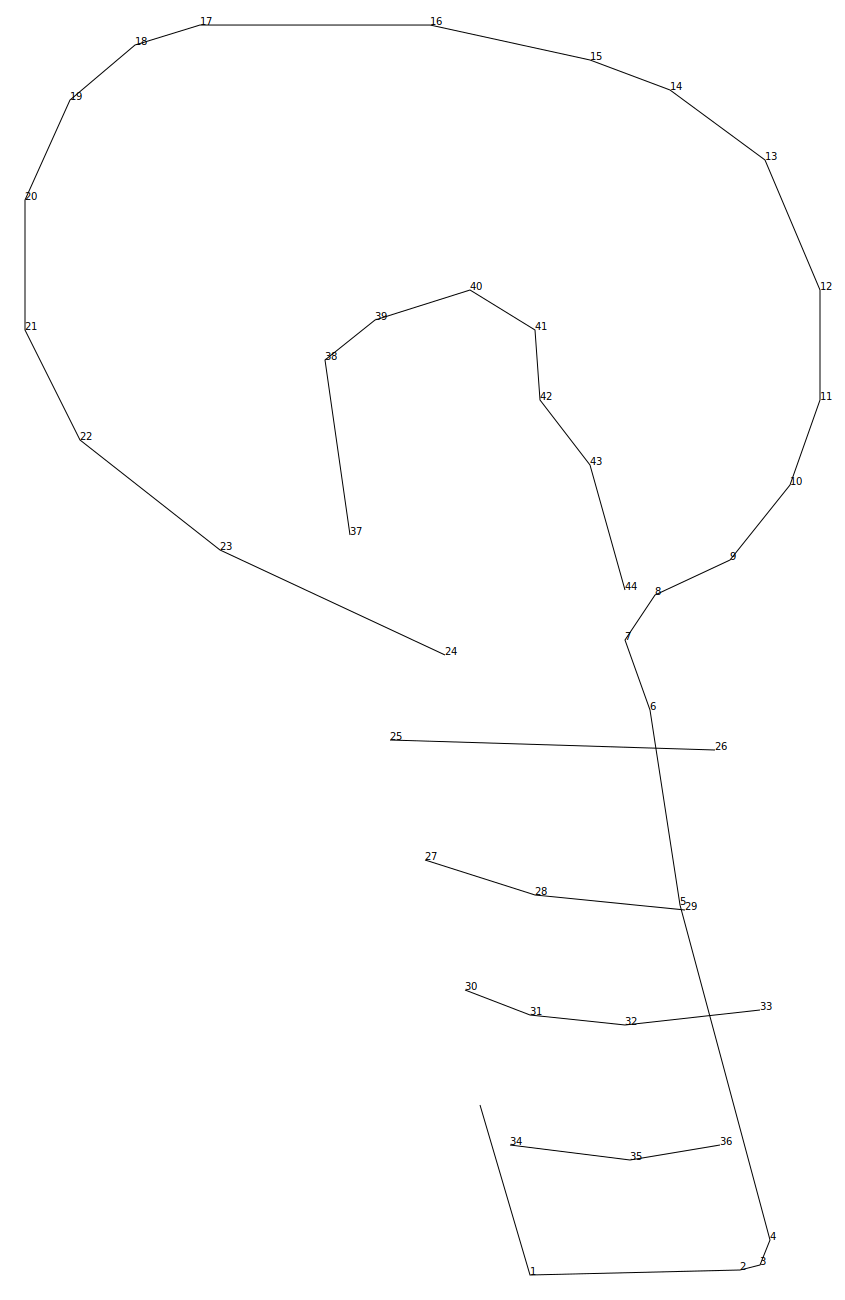

In [26]:
# see data format and draw it
print(train_sketches[0])
draw_strokes(train_sketches[0], show_pen_sequence=True)

In [27]:
def preprocess(sketches, limit=1000):
  raw_data = []
  seq_len = []

  for i in range(len(sketches)):
    data = sketches[i]
    # removes large gaps from the data
    data = np.minimum(data, limit)
    data = np.maximum(data, -limit)
    data = np.array(data, dtype=np.float32)
    raw_data.append(data)
    seq_len.append(len(data))
  seq_len = np.array(seq_len)  # nstrokes for each sketch
  idx = np.argsort(seq_len)
  sketches = []
  for i in range(len(seq_len)):
    sketches.append(raw_data[idx[i]])
  return raw_data


def calculate_normalizing_scale_factor(sketches):
  """Calculate the normalizing factor explained in appendix of sketch-rnn."""
  data = []
  for i in range(len(sketches)):
    for j in range(len(sketches[i])):
      data.append(sketches[i][j, 0])
      data.append(sketches[i][j, 1])
  data = np.array(data)
  return np.std(data)


def normalize(sketches, scale_factor):
  """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
  result = []
  for i in range(len(sketches)):
    tmp = sketches[i]
    tmp[:, 0:2] /= scale_factor
    result.append(tmp)
  return result


def to_big_strokes(strokes):
  """Converts from stroke-3 to stroke-5 format and pads to given length, but does not insert special start token)."""

  result = np.zeros((len(strokes), 5), dtype=float)
  l = len(strokes)
  result[0:l, 0:2] = strokes[:, 0:2]
  result[0:l, 3] = strokes[:, 2]
  result[0:l, 2] = 1 - result[0:l, 3]
  result[l:, 4] = 1
  return result


def to_big_sketches(sketches):
  result = []
  for i in range(len(sketches)):
    sketch = to_big_strokes(sketches[i])
    result.append(sketch)
  return result


def to_normal_strokes(big_strokes):
  """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
  l = 0
  for i in range(len(big_strokes)):
    if big_strokes[i, 4] > 0:
      l = i
      break
  if l == 0:
    l = len(big_strokes)
  result = np.zeros((l, 3))
  result[:, 0:2] = big_strokes[0:l, 0:2]
  result[:, 2] = big_strokes[0:l, 3]
  return result

In [28]:
# preprocess sketches
train_sketches = preprocess(train_sketches)
valid_sketches = preprocess(valid_sketches)
test_sketches = preprocess(test_sketches)

# calculate normailizing factor
normalizing_scale_factor = calculate_normalizing_scale_factor(train_sketches)
print('normalizing_scale_factor {:4.4f}.'.format(normalizing_scale_factor))

# normalize dataset
train_sketches = normalize(train_sketches, normalizing_scale_factor)
valid_sketches = normalize(valid_sketches, normalizing_scale_factor)
test_sketches = normalize(test_sketches, normalizing_scale_factor)

# convert to stroke-5 format
train_sketches = to_big_sketches(train_sketches)
valid_sketches = to_big_sketches(valid_sketches)
test_sketches = to_big_sketches(test_sketches)

normalizing_scale_factor 35.2895.


[[ 0.56674147  2.69202209  0.        ]
 [ 0.28337073  0.96346051  0.        ]
 [ 1.19015706 -0.02833707  0.        ]
 [ 0.11334829 -0.02833707  0.        ]
 [ 0.05667415 -0.14168537  0.        ]
 [-0.51006734 -1.89858389  0.        ]
 [-0.17002244 -1.10514581  0.        ]
 [-0.14168537 -0.39671904  0.        ]
 [ 0.17002244 -0.25503367  0.        ]
 [ 0.4250561  -0.19835952  0.        ]
 [ 0.34004489 -0.4250561   0.        ]
 [ 0.17002244 -0.48173025  0.        ]
 [ 0.         -0.62341559  0.        ]
 [-0.31170779 -0.73676389  0.        ]
 [-0.53840441 -0.39671904  0.        ]
 [-0.45339316 -0.17002244  0.        ]
 [-0.90678632 -0.19835952  0.        ]
 [-1.30350542  0.          0.        ]
 [-0.36838195  0.11334829  0.        ]
 [-0.36838195  0.31170779  0.        ]
 [-0.25503367  0.56674147  0.        ]
 [ 0.          0.73676389  0.        ]
 [ 0.31170779  0.62341559  0.        ]
 [ 0.79343808  0.62341559  0.        ]
 [ 1.2751683   0.59507853  1.        ]
 [-0.31170779  0.48173025

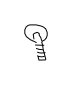

In [29]:
print(to_normal_strokes(train_sketches[0]))
draw_strokes(to_normal_strokes(train_sketches[0]))

In [30]:
# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):

  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max + x_min) * 0.5
    return x_start - center_loc, x_end

  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0] * grid_space + grid_space * 0.5
    grid_x = grid_loc[1] * grid_space_x + grid_space_x * 0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x + loc_x
    new_y_pos = grid_y + loc_y
    result.append([new_x_pos - x_pos, new_y_pos - y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos + delta_pos[0]
    y_pos = new_y_pos + delta_pos[1]
  return np.array(result)

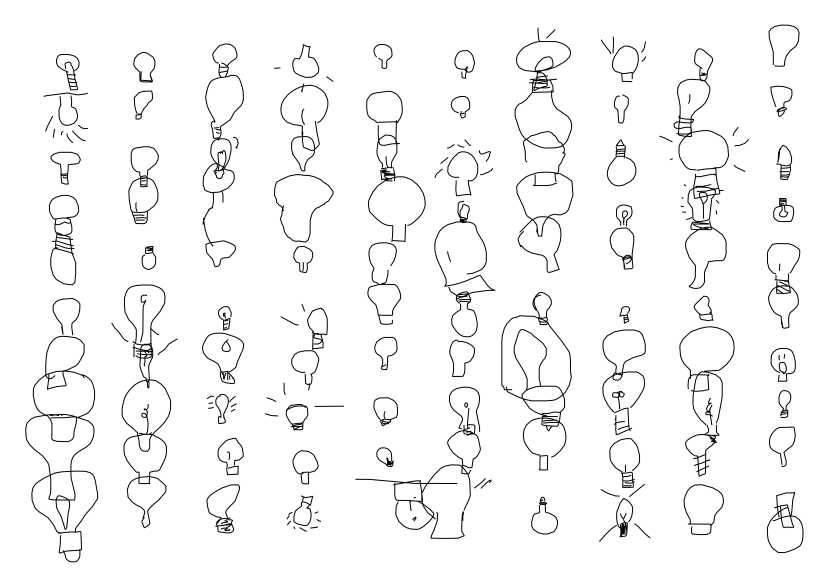

In [31]:
sketches_grid = []
for i in range(10):
  for j in range(10):
    sketches_grid.append(
        [to_normal_strokes(train_sketches[i * 10 + j]), [i, j]])
sketches_grid = make_grid_svg(sketches_grid)
draw_strokes(sketches_grid)

In [22]:
class SRNN_Model():
  
    def __init__(self, hps, model_name='sketch_rnn'):
        self.hps = hps
        self.model_name=model_name
        with tf.variable_scope(model_name, reuse=tf.AUTO_REUSE):
            self.build_model(hps)
    
    def build_model(self, hps):
      
        # input and output
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[], name='batch_size')
        self.input_sequence = tf.placeholder(dtype=tf.float32, shape=[None, hps.max_seq_len+1, 5], name='input_sequence')
        input_sequence = self.input_sequence[:, :-1]
        output_sequence = self.input_sequence[:, 1:, :]
        self.lstm_cell = tf.nn.rnn_cell.LSTMCell(hps.dec_rnn_size)
        self.zero_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        output, _ = tf.nn.dynamic_rnn(self.lstm_cell, input_sequence, initial_state=self.zero_state)
        output = tf.reshape(output, [-1, hps.dec_rnn_size])
        
        # for each input timestamp, output parameters for mixture of gaussian
        num_hidden = hps.num_mixture * 6 + 3 
        def feed_forward(output):
            with tf.variable_scope('feed_forward', reuse=tf.AUTO_REUSE):
                return tf.layers.dense(output, num_hidden)
        output = feed_forward(output)
        ##############################################################################
        
        """
        Loss for mixture of multivariate gaussian. Given (prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3), 
        we want the mixture to output high probility P(delta_x, delta_y|prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3),
        see equation (9) at https://arxiv.org/pdf/1704.03477.pdf
        
        parameters:
            pi: weight of each mixture, shape (batch_size*max_seq_len, num_mixture)
            mu1, mu2: mu of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
            sigma1, sigma2: sigma of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
            corr: correction of (delta_x, delta_y), shape (batch_size*max_seq_len, num_mixture)
        """
        output_params = tf.split(output, num_or_size_splits=[3]+[hps.num_mixture]*6, axis=1)
        output_pen_logits, output_mixture_pi, output_mu1, output_mu2, output_sigma1, output_sigma2, output_corr = output_params
        
        # softmax all the pi's and pen states:
        output_mixture_pi = tf.nn.softmax(output_mixture_pi)
        output_pen_pi = tf.nn.softmax(output_pen_logits)
        
        # exponentiate the sigmas and also make corr between -1 and 1.
        output_sigma1 = tf.exp(output_sigma1)
        output_sigma2 = tf.exp(output_sigma2)
        output_corr = tf.tanh(output_corr)
        
        x1 = tf.reshape(output_sequence[:, :, 0], [-1, 1])
        x2 = tf.reshape(output_sequence[:, :, 1], [-1, 1])
        
        def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
            """
            Returns P(delta_x, delta_y|prev_delta_x, prev_delta_y, prev_p1, prev_p2, prev_p3), 
            see equation (24) of http://arxiv.org/abs/1308.0850 or 
            https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case
            """
            norm1 = tf.subtract(x1, mu1)
            norm2 = tf.subtract(x2, mu2)
            s1s2 = tf.multiply(s1, s2)
            # eq 25
            z = (tf.square(tf.div(norm1, s1)) + tf.square(tf.div(norm2, s2)) -
                 2 * tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2))
            neg_rho = 1 - tf.square(rho) + 1e-6 # avoid divide by zero
            result = tf.exp(tf.div(-z, 2 * neg_rho))
            denom = 2 * np.pi * tf.multiply(s1s2, tf.sqrt(neg_rho))
            result = tf.div(result, denom)
            self.denom = denom
            self.neg_rho = neg_rho
            self.s1s2 = s1s2
            self.s1 = s1
            self.s2 = s2
            return result

        point_prob = tf_2d_normal(x1, x2, output_mu1, output_mu2, output_sigma1, output_sigma2, output_corr)
        point_prob = tf.multiply(point_prob, output_mixture_pi) # multiply weight of each mixture
        point_prob = tf.reduce_sum(point_prob, axis=1)
        
        # loss for indicating if pen should stop
        pen_labels = tf.reshape(output_sequence[:, :, 2:], [-1, 3]) # (batch_size*max_seq_len ,3)
        pen_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=pen_labels, logits=output_pen_logits)
        self.pen_loss = tf.reduce_mean(pen_loss)
        
        # loss for delta x,y
        delta_xy_loss = -tf.log(point_prob + 1e-6)  # avoid log(0)
        mask = 1.0 - pen_labels[:, 2]    
        mask = tf.reshape(mask, [-1, 1])        
        delta_xy_loss = delta_xy_loss * mask
        self.delta_xy_loss = tf.reduce_mean(delta_xy_loss)
        
        
        self.loss = self.pen_loss + self.delta_xy_loss

        # optimize rnn
        self.global_step = tf.get_variable(name='global_step', initializer=tf.constant(0.), trainable=False)
        self.learning_rate = tf.get_variable(name='learning_rate', initializer=tf.constant(hps.learning_rate), trainable=False)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name+'/')
        grad_vars = optimizer.compute_gradients(self.loss, var_list=var_list)
        grad_vars = [(tf.clip_by_value(grad, -hps.grad_clip, hps.grad_clip), var) for grad, var in grad_vars]
        self.train_op = optimizer.apply_gradients(grad_vars, global_step=self.global_step, name='train_step')
        
        #################### tensor for generating a point ############################
        self.prev_state = self.lstm_cell.zero_state(1, dtype=tf.float32)
        self.prev_point = tf.placeholder(tf.float32, shape=[1,5], name='prev_point')
        output, self.next_state = self.lstm_cell(self.prev_point, self.prev_state)
        output = tf.reshape(output, [-1, hps.dec_rnn_size])
        output = feed_forward(output)
        self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr = \
                                                              tf.split(output[:,3:], num_or_size_splits=6, axis=1)
        pen_logits = output[:,:3]
        self.output_pi = tf.nn.softmax(self.output_pi)
        self.pen_pi = tf.nn.softmax(pen_logits)
        self.output_sigma1 = tf.exp(self.output_sigma1)
        self.output_sigma2 = tf.exp(self.output_sigma2)
        self.output_corr = tf.tanh(self.output_corr)
        
    def generate_stroke(self, sess, prev_sketch, temperature = 0.1, greedy = False):
        """
        *****************************IMPORTANT*****************************
        1. your model must have this function, or error happen when evaluation.
        2. the length of stroke must less than 10, which means you can at most generate 10 points.
        *******************************************************************
        this function return a stroke given previous generated sketch
        """
        # feed previous sketch to get hidden state
        prev_state = sess.run(self.zero_state, feed_dict={self.batch_size: 1})
        for i in range(len(prev_sketch)-1):
            feed_dict = {
                    self.prev_state: prev_state,
                    self.prev_point: [prev_sketch[i]],
            }
            prev_state = sess.run(self.next_state, feed_dict)
        
        # start to generate next stroke
        prev_point = [prev_sketch[-1]]
        generated_stroke = []
        while len(generated_stroke) < 10: 
            feed_dict = {
                self.prev_state: prev_state,
                self.prev_point: prev_point,
            }
            params = sess.run([
                self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr,
                self.pen_pi, self.next_state
            ], feed_dict)

            [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params
            
            # sample index of bivarite normal in mixture to use
            idx = get_pi_idx(np.random.random(), o_pi[0], temperature, greedy)
            
            # sample index of pen state
            idx_eos = get_pi_idx(np.random.random(), o_pen[0], temperature, greedy)
            eos = [0, 0, 0]
            eos[idx_eos] = 1

            # use one bivarite normal to generate next (delta_x, delta_y)
            next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                                  o_sigma1[0][idx], o_sigma2[0][idx],
                                                  o_corr[0][idx], np.sqrt(temperature), greedy)

            prev_point = np.zeros([1,5])
            prev_point[0, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
            prev_state = next_state
            generated_stroke.append(prev_point)
            
            # if this stroke stop
            if prev_point[0][4]==1:
                generated_stroke[-1][0][:2] = 0
            if prev_point[0][4]==1 or prev_point[0][3]==1:
                break
        # pen state should end with p2=1 or p3=1
        if generated_stroke[-1][0][2] == 1:
            generated_stroke[-1][0][2:] = [0.,1.,0.]
        return np.concatenate(generated_stroke, axis=0)    
  
    def generate_sketches(self, sess, num_generate, temperature, greedy=False):
        initial_point = np.array([[0.,0.,1.,0.,0.]])
        initial_state = sess.run(self.zero_state, feed_dict={self.batch_size: 1})
        return_sketches = []
        for i in range(num_generate):
            sketch = [initial_point]
            prev_point = initial_point
            prev_state = initial_state
            for j in range(self.hps.max_seq_len):
                feed_dict = {
                    self.prev_state: prev_state,
                    self.prev_point: prev_point,
                }
                params = sess.run([
                    self.output_pi, self.output_mu1, self.output_mu2, self.output_sigma1, self.output_sigma2, self.output_corr,
                    self.pen_pi, self.next_state
                ], feed_dict)

                [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params
                idx = get_pi_idx(random.random(), o_pi[0], temperature, greedy)

                idx_eos = get_pi_idx(random.random(), o_pen[0], temperature, greedy)
                eos = [0, 0, 0]
                eos[idx_eos] = 1

                next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                                      o_sigma1[0][idx], o_sigma2[0][idx],
                                                      o_corr[0][idx], np.sqrt(temperature), greedy)

                prev_point = np.zeros([1,5])
                prev_point[0, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
                prev_state = next_state
                
                # select a multivariate normal in mixture to draw next point
                sketch.append(prev_point)
                if prev_point[0][4]==1:
                    sketch[-1][0][:2] = 0
                    break
            return_sketches.append(np.concatenate(sketch, axis=0))
        return return_sketches
    
    def train(self, sess, x_train, x_valid, x_test, num_epoch=20, batch_size=100):
        start = time.time()
        best_valid_cost = np.inf
        counter = 0
        patience = 20
        num_epoch = 100
        batch_size = 100
        for epoch in range(num_epoch):
            def gen_batch(x):
                shuffle_idx = np.random.permutation(len(x))
                x = x[shuffle_idx]
                num_batch = len(x)//batch_size
                for i in range(num_batch):
                    yield x[i*batch_size:(i+1)*batch_size]
            losses = []
            delta_xy_losses = []
            pen_losses = []
            for x_batch in gen_batch(x_train):
                step = sess.run(self.global_step)
                curr_learning_rate = ((hps.learning_rate - hps.min_learning_rate) *
                                      (hps.decay_rate)**step + hps.min_learning_rate)    
                feed_dict = {
                    self.input_sequence: x_batch,
                    self.learning_rate: curr_learning_rate,
                    self.batch_size: len(x_batch)
                }
                (loss, delta_xy_loss, pen_loss, _) = sess.run([self.loss, self.delta_xy_loss, 
                                                               self.pen_loss, self.train_op], feed_dict)
                losses.append(loss)
                delta_xy_losses.append(delta_xy_loss)
                pen_losses.append(pen_loss)
                if step % 20 == 0 and step > 0:
                    end = time.time()
                    time_taken = end - start
                    tf.logging.info(('step: {}, learning_rate: {:.4f}, loss: {:.4f}, xy_loss: {:.4f}, '+
                                     'pen_loss: {:.4f}, time_taken: {:.2f}').format(step, curr_learning_rate, 
                                      np.mean(losses), np.mean(delta_xy_losses), np.mean(pen_losses), time_taken))
                    losses = []
                    delta_xy_losses = []
                    pen_losses = []
                    start = time.time()
                if step % 1000 == 0 and step > 0:
                    N = 10
                    sketches = self.generate_sketches(sess, num_generate=N, temperature=0.5)
                    reconstructions = []
                    for i in range(N):
                        reconstructions.append([to_normal_strokes(sketches[i]), [0, i]])
                    stroke_grid = make_grid_svg(reconstructions)
                    draw_strokes(stroke_grid)

                if step % self.hps.save_every == 0 and step > 0:
                    start = time.time()
                    test_losses = []
                    test_delta_xy_losses = []
                    test_pen_losses = []
                    for x_batch in gen_batch(x_valid):
                        feed_dict = {
                            self.input_sequence: x_batch,
                            self.batch_size: len(x_batch)
                        }

                        (loss, delta_xy_loss, pen_loss) = sess.run([self.loss, self.delta_xy_loss, self.pen_loss], feed_dict)
                        test_losses.append(loss)
                        test_delta_xy_losses.append(delta_xy_loss)
                        test_pen_losses.append(pen_loss)

                    end = time.time()
                    time_taken = end - start
                    tf.logging.info(('validation, step: {}, loss: {:.4f}, xy_loss: {:.4f}, '+
                                     'pen_loss: {:.4f}, time_taken: {:.2f}').format(step, np.mean(test_losses), 
                                      np.mean(test_delta_xy_losses), np.mean(test_pen_losses), time_taken))                    
                    start = time.time()

                    if np.mean(test_losses) < best_valid_cost:
                        best_valid_cost = np.mean(test_losses)
                        self.save_model(sess, step=step)
                        test_losses = []
                        test_delta_xy_losses = []
                        test_pen_losses = []
                        for x_batch in gen_batch(x_test):
                            feed_dict = {
                                self.input_sequence: x_batch,
                                self.batch_size: len(x_batch)
                            }

                            (loss, delta_xy_loss, pen_loss) = sess.run([self.loss, self.delta_xy_loss, self.pen_loss], feed_dict)
                            test_losses.append(loss)
                            test_delta_xy_losses.append(delta_xy_loss)
                            test_pen_losses.append(pen_loss)

                        end = time.time()
                        time_taken = end - start
                        tf.logging.info(('testing, step: {}, loss: {:.4f}, xy_loss: {:.4f}, '+
                                         'pen_loss: {:.4f}, time_taken: {:.2f}').format(step, np.mean(test_losses), 
                                          np.mean(test_delta_xy_losses), np.mean(test_pen_losses), time_taken))
                        counter = 0
                    else:
                        counter += 1
                        if counter > patience:
                            tf.logging.info('early stop!!')
                            return
    def save_model(self, sess, checkpoint_dir='./checkpoints',step=None):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name+'/'))
        if step is not None:
            saver.save(sess, os.path.join(checkpoint_dir, self.model_name), global_step=step)
            tf.logging.info('model save to {}-{}'.format(os.path.join(checkpoint_dir, self.model_name), step))
        else:
            saver.save(sess, os.path.join(checkpoint_dir, self.model_name))
            tf.logging.info('model save to {}'.format(os.path.join(checkpoint_dir, self.model_name)))
        
    def load_model(self, sess, checkpoint_dir='./checkpoints', step=None):
        saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.model_name+'/'))
        if step is not None:
            saver.restore(sess, os.path.join(checkpoint_dir, self.model_name+'-{}'.format(step)))
        else:
            saver.restore(sess, os.path.join(checkpoint_dir, self.model_name))

In [6]:
def get_default_hparams():
  """Return default HParams for sketch-rnn."""
    hparams = tf.contrib.training.HParams(
      data_set=['aaron_sheep.npz'],  # Our dataset.
      save_every=2000,  # Number of batches per checkpoint creation.
      max_seq_len=250,  # Not used. Will be changed by model. [Eliminate?]
      dec_rnn_size=1024,  # Size of decoder.
      batch_size=100,  # Minibatch size. Recommend leaving at 100.
      grad_clip=1.0,  # Gradient clipping. Recommend leaving at 1.0.
      num_mixture=20,  # Number of mixtures in Gaussian mixture model.
      learning_rate=0.001,  # Learning rate.
      decay_rate=0.9999,  # Learning rate decay per minibatch.
      kl_decay_rate=0.99995,  # KL annealing decay rate per minibatch.
      min_learning_rate=0.00001,  # Minimum learning rate.
      use_recurrent_dropout=True,  # Dropout with memory loss. Recomended
      recurrent_dropout_prob=0.90,  # Probability of recurrent dropout keep.
      use_input_dropout=False,  # Input dropout. Recommend leaving False.
      input_dropout_prob=0.90,  # Probability of input dropout keep.
      use_output_dropout=False,  # Output droput. Recommend leaving False.
      output_dropout_prob=0.90,  # Probability of output dropout keep.
      random_scale_factor=0.15,  # Random scaling data augmention proportion.
      augment_stroke_prob=0.10,  # Point dropping augmentation proportion.
      conditional=True,  # When False, use unconditional decoder-only model.
      is_training=True  # Is model training? Recommend keeping true.
    )
    return hparams
# function used to generate next point
def adjust_temp(pi_pdf, temp):
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a pdf, optionally greedily."""
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error with sampling ensemble.')
    return -1

def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
    if greedy:
        return mu1, mu2
    mean = [mu1, mu2]
    s1 *= temp * temp
    s2 *= temp * temp
    cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

###  In the following, we insert start token and pad each sketch to make them have same length.

In [32]:
def pad_data(sketches, max_seq_len):
  """Pad the batch to be stroke-5 bigger format as described in paper."""
  result = np.zeros((len(sketches), max_seq_len + 1, 5), dtype=float)
  for i in range(len(sketches)):
    l = len(sketches[i])
    result[i, 0:l, :] = sketches[i][:, :]
    result[i, l:, 4] = 1

    # put in the first token, as described in sketch-rnn methodology
    result[i, 1:, :] = result[i, :-1, :]
    result[i, 0, :] = 0
    result[i, 0, 2] = 1  # setting S_0 from paper.
  return result


def get_max_len(sketches):
  """Return the maximum length of an array of strokes."""
  max_len = 0
  for sketch in sketches:
    ml = len(sketch)
    if ml > max_len:
      max_len = ml
  return max_len

In [33]:
# get max sequence length and pad data
max_seq_len = get_max_len(train_sketches)
x_train = pad_data(train_sketches, max_seq_len)
x_valid = pad_data(valid_sketches, max_seq_len)
x_test = pad_data(test_sketches, max_seq_len)

In [35]:
hps = get_default_hparams()
hps.max_seq_len = max_seq_len

In [38]:
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
random.seed(123)
model = SRNN_Model(hps, model_name='balloon')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

AttributeError: module 'tensorflow.python.ops.nn' has no attribute 'softmax_cross_entropy_with_logits_v2'

In [39]:
print(tf.__version__)

1.4.0
